In [1]:
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

# Предсказывать будем цены, а не доходности.
Так как цены сами по себе предсказывать спроще, они менее похожи на шум, а также подлежат более-менее нормальной декомпозиции. Доходности же можно вычислить, исходя из формулы: $${r_t = \frac{y_t}{y_{t - 1} } - 1}$$

# Загрузка данных

In [2]:
df = pd.read_csv("../Data/American Companies/FORD 1994 2022.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,02.06.1972,2.153220,2.173495,2.141055,2.149165,0.266799,1174468
1,05.06.1972,2.149165,2.169440,2.141055,2.149165,0.266799,5209582
2,06.06.1972,2.149165,2.157275,2.116725,2.124835,0.263778,1424158
3,07.06.1972,2.124835,2.137000,2.112670,2.112670,0.262268,675088
4,08.06.1972,2.112670,2.128890,2.096449,2.096449,0.260255,1038834
...,...,...,...,...,...,...,...
12740,08.12.2022,13.200000,13.260000,13.070000,13.120000,13.120000,32376300
12741,09.12.2022,13.040000,13.360000,13.040000,13.180000,13.180000,41531600
12742,12.12.2022,13.200000,13.470000,13.100000,13.460000,13.460000,35473800
12743,13.12.2022,13.780000,13.920000,13.370000,13.570000,13.570000,57872100


In [3]:
open_price = df.Open
date = df.Date.apply(lambda x: pd.to_datetime(x, dayfirst= True))

In [4]:
bad_data = []
for ind, el in enumerate(open_price):
    try:
        float(el)
        assert(el != "0")
    except:
        print(el)
        bad_data.append(ind)

In [5]:
bad_data = np.array(bad_data)

In [6]:
open_price = open_price.drop(bad_data)
dates = date.drop(bad_data)

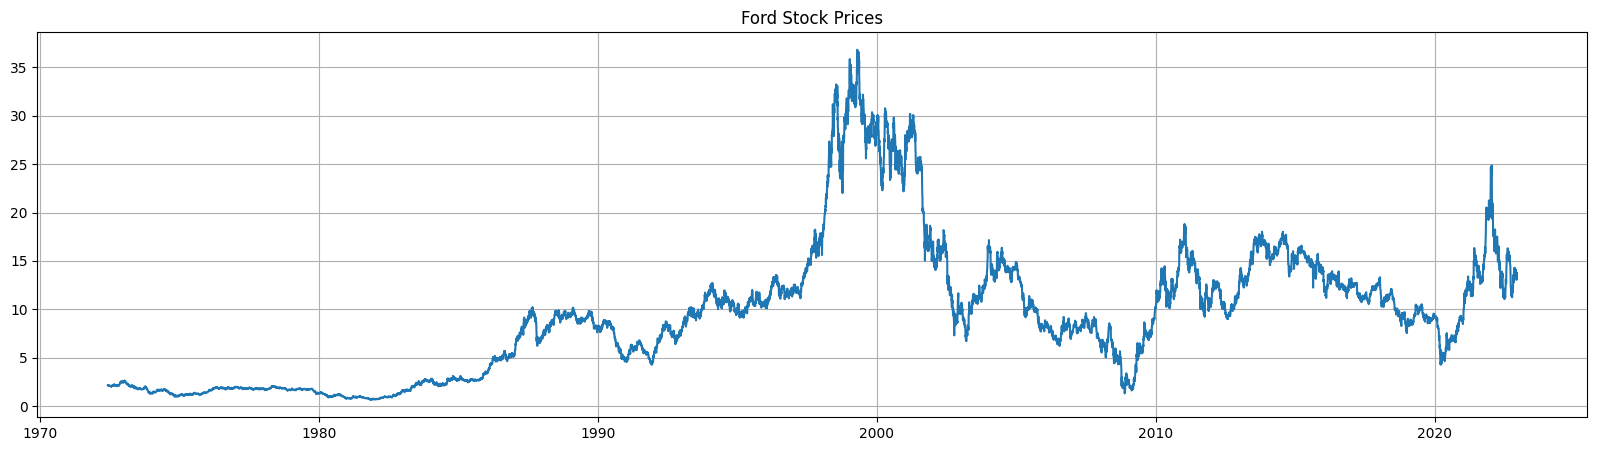

In [7]:
plt.figure(figsize= (20, 5))
plt.title("Ford Stock Prices")
plt.plot(dates, open_price)
plt.grid(True)
plt.show()

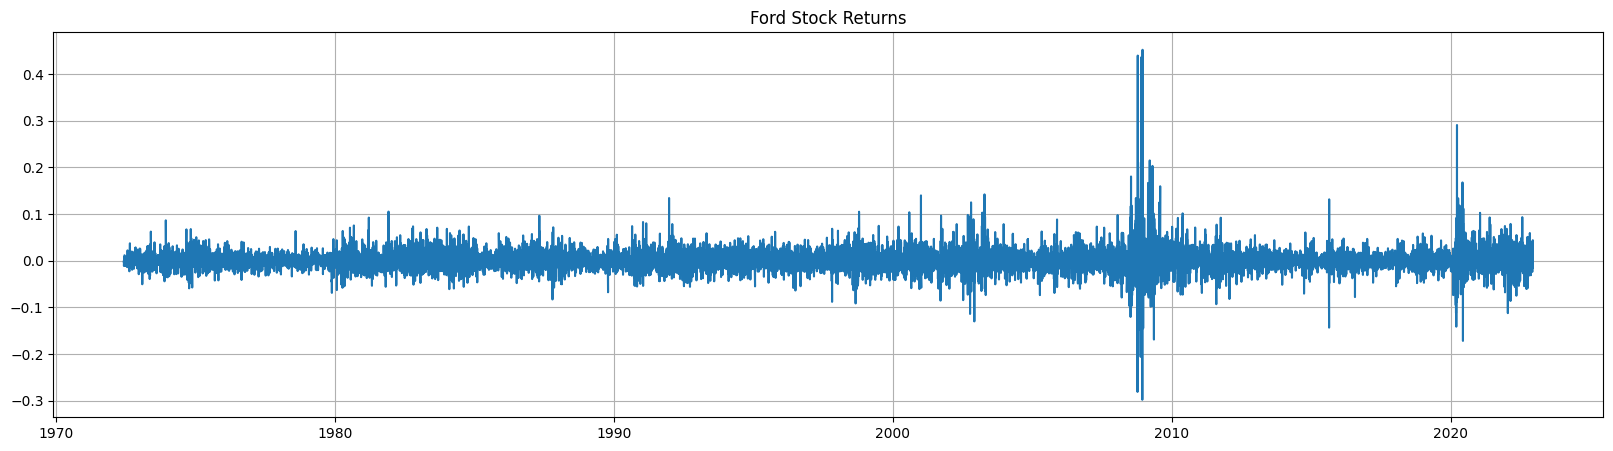

In [8]:
plt.figure(figsize= (20, 5))
plt.title("Ford Stock Returns")
plt.plot(dates[1:], open_price.pct_change()[1:])
plt.grid(True)
plt.show()

In [9]:
open_price = open_price.astype(np.float32).to_numpy()
dates = dates.to_numpy()

# Преобразование данных во входные данные

In [10]:
def data_to_X_y(x, window_size= 40):
    X = []
    y = []
    for i in range(len(x) - window_size):
        row = list(map(lambda a: [a], x[i:i + window_size]))
        X.append(np.array(row))
        col = [x[i + window_size]]
        y.append(np.array(col))

    return np.array(X), np.array(y)

### Разложение ряда на шум и тренд (сезонности нет)

In [11]:
from SSA.SSA import SSA

In [21]:
N = len(open_price)
L = 200
K = N - L + 1

open_price_matrix = SSA.x_to_Hankelian(open_price, L, K)
U, S, Vt = np.linalg.svd(open_price_matrix)
V = Vt.T

x_hat = np.array([SSA.Hankelian_to_TS(SSA.get_elementry_matrix(U[:, i].reshape(-1, 1), S[i], V[:, i])) for i in range(len(S))])

U.shape, V.shape, x_hat.shape

((200, 200), (12546, 12546), (200, 12745))

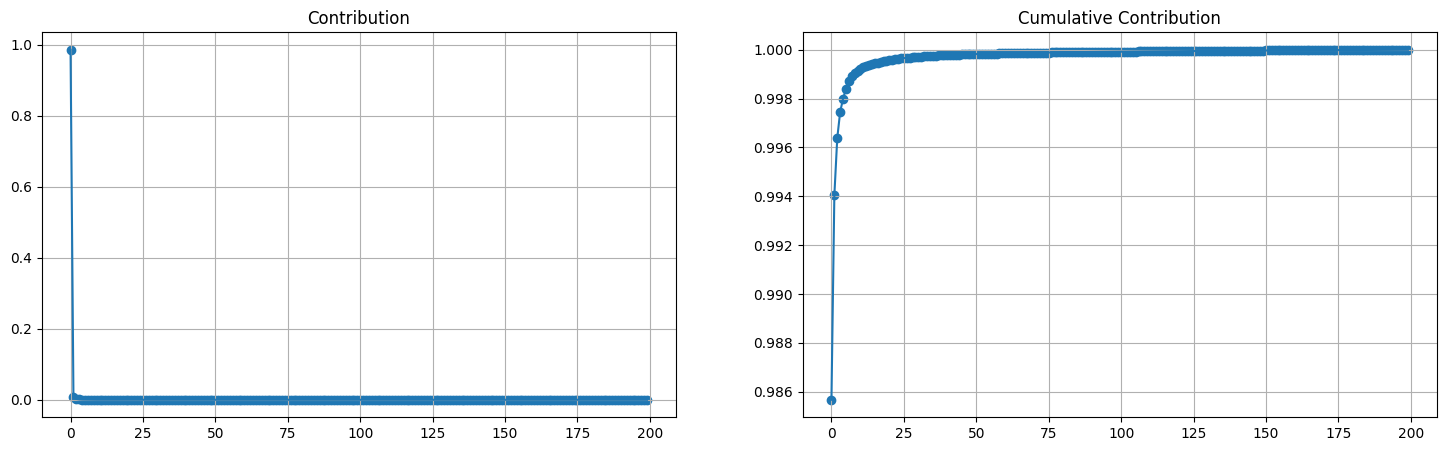

In [22]:
res = SSA.get_contribution(S)
SSA.plot_contribution(res);

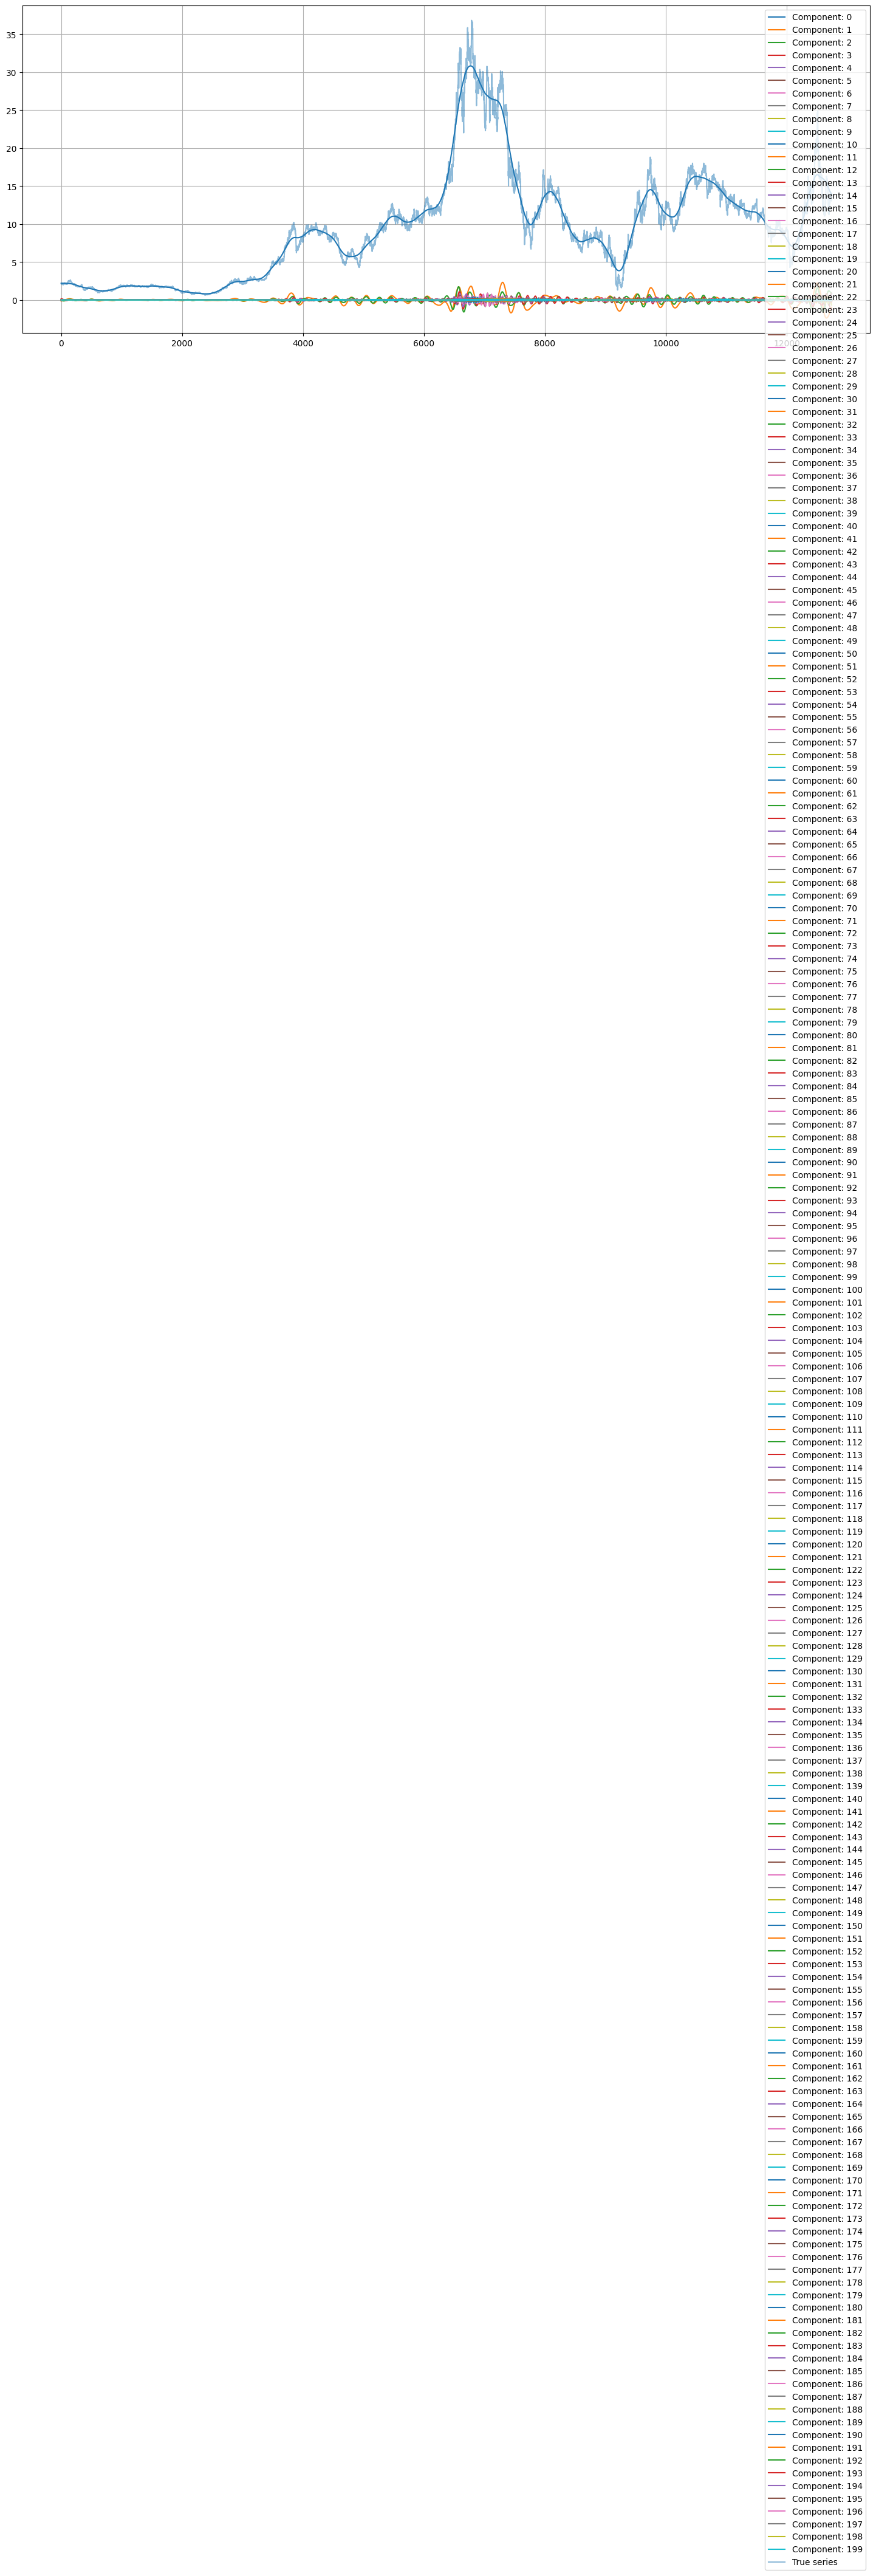

In [23]:
SSA.plot_x_hat(x_hat, open_price)

In [24]:
d = len(S[S > 0])
W_corr = SSA.get_W_corr_matrix(x_hat, d, K, L)

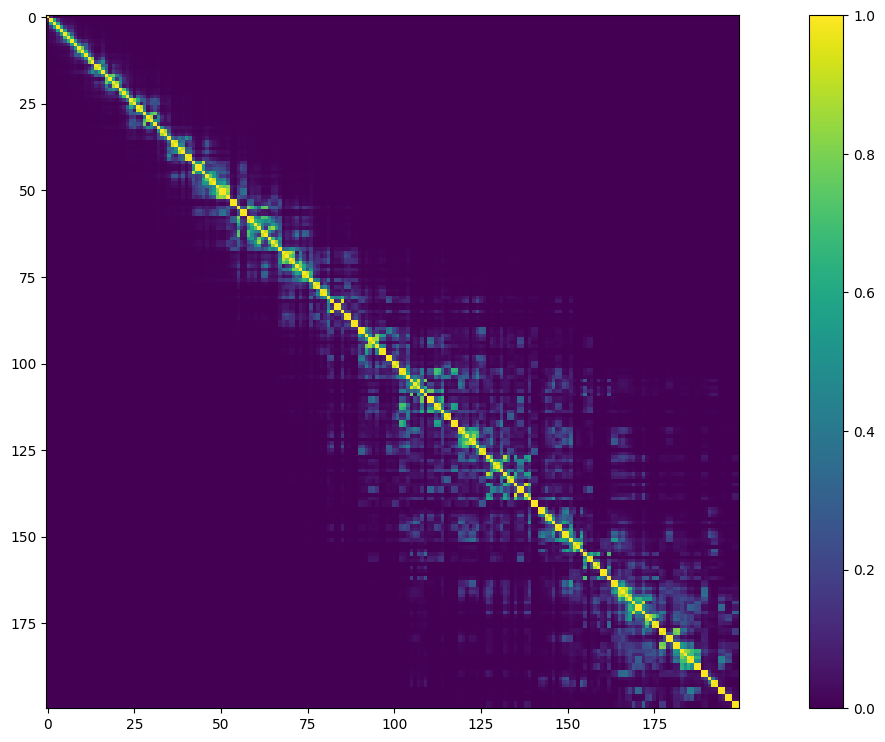

In [25]:
SSA.plot_W_corr(W_corr);

### Алгоритм группировки восстановленых элементов ряда
Основан на статье [Николая Владимировича Абалова](https://www.researchgate.net/publication/297898415_Automatic_Grouping_of_Time_Series_Decomposition_Components_in_Singular_Spectrum_Analysis).
В нашем случае ${y_t = S_t + T_t + \varepsilon_t}$, но ${S_t}$ в ценах акций нет, иначе рынок бы сломался ${\Rightarrow y_t = T_t + \varepsilon_t}$, где ${\varepsilon_t}$ - шум. Наша задача - отделить тренд от шума.

In [ ]:
eigen_values = np.power(S, 2)
similarity_eigen_values = np.zeros((eigen_values.shape[0], eigen_values.shape[0]), dtype= np.float64)
similarity_eigen_values.shape

In [ ]:
# Вычисляем матрицу схожести собственных чисел
for i in range(similarity_eigen_values.shape[0]):
    for j in range(i, similarity_eigen_values.shape[1]):
        similarity_eigen_values[i, j] = min(eigen_values[i], eigen_values[j]) / max(eigen_values[i], eigen_values[j])
        # для дальнейшних изысканий нет необходимости делать симметрию, так как матрицы и так симметрична
        # similarity_eigen_values[j, i] = similarity_eigen_values[i, j]

In [ ]:
# threshold -> выбор порогов
rho_c = 0.5 # корреляция значима при ее показателе >= 0.3 (для матрицы корреляции восстановленных компонент)
rho_one = 0.99 # близость собственных чисел рассматривается только в случае >= 0.99 (для матрицы схожести собственных чисел)

In [ ]:
ind_W_corr = (W_corr >= rho_c).astype(np.int64)
ind_similarity_eigen_values = (similarity_eigen_values >= rho_one).astype(np.int64)
G = ind_W_corr * ind_similarity_eigen_values

In [ ]:
plt.figure(figsize= (18, 9))
axis = plt.imshow(G.astype(np.float64))
plt.colorbar(axis.colorbar);

In [ ]:
selected_components = G.sum(axis= 0).astype(bool)
selected_components

In [ ]:
selected_x = x_hat[selected_components, :]
reconstructed_x = selected_x.sum(axis= 0)

In [ ]:
SSA.plot_x_hat(np.array([reconstructed_x]), open_price)

In [ ]:
residuals = open_price - reconstructed_x

### Формирование матрицы траекторий

In [ ]:
WINDOW_SIZE = 70 #40
X, y = data_to_X_y(reconstructed_x, window_size= WINDOW_SIZE)
dates_x, dates_y = data_to_X_y(dates, window_size= WINDOW_SIZE)

X = torch.from_numpy(X).to(torch.float32)
y = torch.from_numpy(y).to(torch.float32)

X.shape, X.dtype, y.shape, y.dtype

# Разбивка на обучение и тест

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size= 0.1,
    shuffle= False
)

dates_train_x, dates_test_x, dates_train_y, dates_test_y = train_test_split(
    dates_x, dates_y,
    test_size= 0.1,
    shuffle= False
)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size= 0.1,
    shuffle= False
)

dates_train_x, dates_val_x, dates_train_y, dates_val_y = train_test_split(
    dates_train_x, dates_train_y,
    test_size= 0.1,
    shuffle= False
)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

In [ ]:
dates_train_x.shape, dates_train_y.shape, dates_val_x.shape, dates_val_y.shape, dates_test_x.shape, dates_test_y.shape

# Скалирование данных

In [ ]:
class MinMaxScaler():
    def __init__(self):
        self.min = 0
        self.max = 1

    def fit(self, data):
        self.min = data.min()
        self.max = data.max()

    def transform(self, data):
        return (data - self.min) / (self.max - self.min)

    def inverse_transform(self, data):
        return (self.max - self.min) * data + self.min

    def __str__(self):
        return f"Min: {self.min}\nMax: {self.max}"

class StandardScaler():
    def __init__(self):
        self.mean = 0
        self.std = 1

    def fit(self, data):
        self.mean = data.mean()
        self.std = data.std()

    def transform(self, data):
        return (data - self.mean) / self.std

    def inverse_transform(self, data):
        return self.std * data + self.mean

    def __str__(self):
        return f"Mean: {self.mean}\nStd: {self.std}"

scaler = MinMaxScaler()
scaler.fit(torch.concat((X_train[0], y_train, y_val), dim= 0))

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

y_train_scaled = scaler.transform(y_train)
y_val_scaled = scaler.transform(y_val)
y_test_scaled = scaler.transform(y_test)

In [ ]:
print(scaler)

# Создание датасетов и загрузчиков

In [ ]:
class TimeSeriesDataSet(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, item):
        return self.X[item], self.y[item]

In [ ]:
train_dataset = TimeSeriesDataSet(X_train_scaled, y_train_scaled)
val_dataset = TimeSeriesDataSet(X_val_scaled, y_val_scaled)
test_dataset = TimeSeriesDataSet(X_test_scaled, y_test_scaled)

In [ ]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size= 256,
    shuffle= False
)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size= 256,
    shuffle= False
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size= 256,
    shuffle= False,
)

# Построение модели

In [ ]:
class StockPredictor(nn.Module):
    def __init__(
            self,
            input_dim,
            hid_dim,
            out_dim,
            num_layers= 1,
            dropout= 0.0,
            type= "gru"
    ):
        super(StockPredictor, self).__init__()
        self.input_dim = input_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim

        self.num_layers = num_layers
        self.dropout = dropout
        self.type = type

        assert self.type in ["gru", "lstm", "rnn"], "Unknown block"

        self.recurrent_block = None
        if self.type == "gru":
            self.recurrent_block = nn.GRU(
                self.input_dim, self.hid_dim,
                num_layers= self.num_layers,
                batch_first= True,
                dropout= self.dropout)
        elif self.type == "rnn":
            self.recurrent_block = nn.RNN(
                self.input_dim, self.hid_dim,
                num_layers= self.num_layers,
                batch_first= True,
                dropout= self.dropout)
        else:
            self.recurrent_block = nn.LSTM(
                self.input_dim, self.hid_dim,
                num_layers= self.num_layers,
                batch_first= True,
                dropout= self.dropout)

        self.act = nn.Tanh()
        self.fc = nn.Linear(self.hid_dim, self.out_dim)

    def forward(self, X, device= "cpu"):
        h = torch.zeros((self.num_layers, X.shape[0], self.hid_dim)).to(device)
        c = torch.zeros((self.num_layers, X.shape[0], self.hid_dim)).to(device)

        if self.type in ["gru", "rnn"]:
            ans, h = self.recurrent_block(X, h)
            return self.fc(self.act(ans[:, -1]))
        else:
            ans, (h, c) = self.recurrent_block(X, (h, c))
            return self.fc(self.act(ans[:, -1]))

# Функция обучения и тестового вычисления, а также построение графиков

$${sMAPE = \frac{100}{n} \sum_{t = 1}^n \frac{|F_t - A_t|}{|F_t + A_t| / 2}}$$
$${WAPE = \frac{\sum_{t = 1}^{n}|A_t - F_t|}{\sum_{t = 1}^{n}|A_t|}}$$
$${MAPE = \sum_{t = 1}^{n}\frac{|A_t - F_t|}{|A_t|}}$$

In [ ]:
from Functions.Metrics import Metrics
from Functions.Train_Eval_Plot import Train_Eval_Plot

In [ ]:
metrics_dict = Metrics()

# Обучение модели

In [ ]:
torch.manual_seed(42)

params = {
    "input_dim": X_train.shape[-1],
    "hid_dim": 64,
    "out_dim": 1,
    "num_layers": 5,
    "type": "lstm",
    "dropout": 0.0
}

model = StockPredictor(**params)

In [ ]:
epochs = 50
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr= 3e-4)
metric_name = "WAPE"

train_params = {
    "model": model,
    "criterion": criterion,
    "metric": metrics_dict[metric_name],
    "optimizer": optimizer,
    "epochs": epochs,
    "train_data": {
        "train": train_loader,
        "val": val_loader
    },
    "verbose": False,
    "lag": 1,
    "metric_to_max": False,
    "device": "cuda"
}
train_res = Train_Eval_Plot.train(**train_params)

In [ ]:
Train_Eval_Plot.plot_train_res(train_res)

In [ ]:
model.load_state_dict(train_res["best model"])

In [ ]:
eval_res = Train_Eval_Plot.eval(model, test_loader, metrics_dict[metric_name], criterion, device= "cpu")

In [ ]:
Train_Eval_Plot.plot_eval_res(eval_res, y_test_scaled, scaler, dates_test_y, start= -200, end= None)

# Вычисление доходностей

In [ ]:
predicted_open_prices = pd.DataFrame({
    "Test predictions": scaler.inverse_transform(eval_res["test preds"]).reshape(-1),
    "Test ground trouth": y_test.reshape(-1),
}, index= pd.to_datetime(dates_test_y.reshape(-1), dayfirst= True))

predicted_open_prices

In [ ]:
pct_change = predicted_open_prices.pct_change()[1:]

predicted_pct_changes = np.array(pct_change["Test predictions"])
test_values = np.array(pct_change["Test ground trouth"])
dates = list(predicted_open_prices.index)[1:]

metric_value = metrics_dict.metrics_dict["WAPE"]()(predicted_pct_changes, test_values)

In [ ]:
from matplotlib import rcParams

rcParams["figure.figsize"] = 20, 5
print(f"WAPE: {metric_value:.2f}%")
plt.plot(dates[-200:], predicted_pct_changes[-200:], label= "Predicted")
plt.plot(dates[-200:], test_values[-200:], label= "Actual")
plt.grid(True)
plt.legend(loc= "best")
plt.show()